In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import cv2
import os
import time
import pickle

from ssd_data import InputGenerator
from sl_utils import PriorUtil
from ssd_utils import load_weights, count_parameters, calc_memory_usage
from ssd_training import Logger, LearningRateDecay
from sl_training import SegLinkLoss, SegLinkFocalLoss
from sl_metric import evaluate_results
from ssd_metric import fscore

Using TensorFlow backend.


In [2]:
from data_synthtext import GTUtility

file_name = 'gt_util_synthtext_seglink.pkl'
with open(file_name, 'rb') as f:
    gt_util = pickle.load(f)
gt_util_train, gt_util_val = gt_util.split(gt_util, split=0.9)
gt_util_train, _ = gt_util.split(gt_util_train, split=0.25)
gt_util_val, _ = gt_util.split(gt_util_val, split=0.25)

print(gt_util)

Background              0
Text              7266338

images             858749
objects           7266338
per image            8.46
no annotation           0



In [3]:
from sl_model import SL384x512_dense
model = SL384x512_dense()

In [4]:
for i in range(len(model.source_layers)):
    l = model.source_layers[i]
    print('%-2s %s' %(i, l.get_shape().as_list()))
print()
count_parameters(model)
calc_memory_usage(model)

c = 0
for l in model.layers:
    if l.__class__.__name__ == "Conv2D":
        c += 1
print(c)

0  [None, 96, 128, 576]
1  [None, 48, 64, 640]
2  [None, 24, 32, 512]
3  [None, 12, 16, 384]
4  [None, 6, 8, 256]
5  [None, 3, 4, 128]

trainable              5394458
non-trainable            26176
model memory usage     1.40 GB
72


In [5]:
from ssd_data import preprocess

inputs = []
images = []
data = []

gtu = gt_util_val
image_size = model.image_size

np.random.seed(1337)

for i in [0]: #np.random.randint(0, gtu.num_samples, 16):

    img_path = os.path.join(gtu.image_path, gtu.image_names[i])
    img = cv2.imread(img_path)
    print('img_shape', img.shape)
    
    image_size_cv = image_size[::-1]
    print('image_size_ssd', image_size)
    print('image_size_cv ', image_size_cv)
    inpt = preprocess(img, image_size_cv)
    inputs.append(inpt)
    print('image_size_inp', inpt.shape)
    
    img = cv2.resize(img, image_size_cv, cv2.INTER_LINEAR).astype('float32') # should we do resizing
    print('image_size_img', img.shape)
    img = img[:, :, (2,1,0)] # BGR to RGB
    img /= 255
    images.append(img)
    
    boxes = gtu.data[i]
    data.append(boxes)
    
    print()

inputs = np.asarray(inputs)

test_idx = 0
test_input = inputs[test_idx]
test_img = images[test_idx]
test_gt = data[test_idx]

img_shape (472, 600, 3)
image_size_ssd (384, 512)
image_size_cv  (512, 384)
image_size_inp (512, 384, 3)
image_size_img (384, 512, 3)



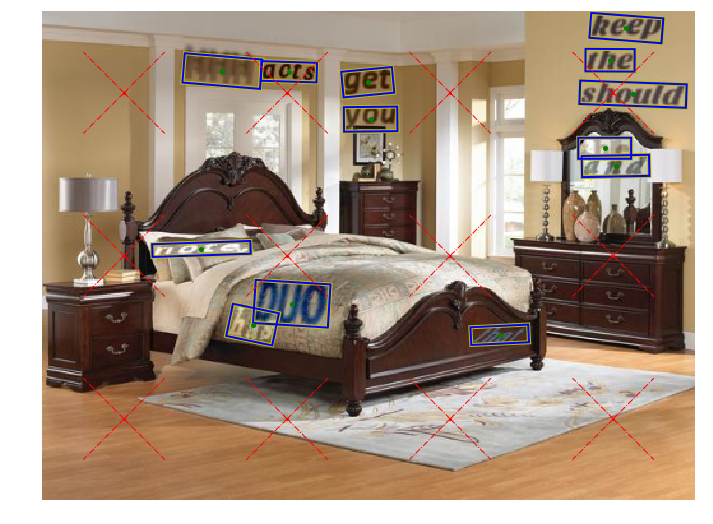

In [6]:
prior_util = PriorUtil(model)

plt.figure(figsize=[12,9])
plt.axis('off')
plt.axis('equal')
plt.imshow(test_img)

prior_util.encode(test_gt, debug=False)

loc_idxs = [0,30,60,80]
loc_idxs = list(range(1000))

for m_idx in [5]:
#for m_idx in [0,1,2,3,4,5]:
    #prior_util.prior_maps[m_idx-1].plot_locations()
    m = prior_util.prior_maps[m_idx]
    m.plot_locations()
    #m.plot_boxes(loc_idxs)
    #prior_util.plot_neighbors(m_idx, loc_idxs, cross_layer=False)
    prior_util.plot_neighbors(m_idx, loc_idxs, inter_layer=False)
    prior_util.plot_assignement(m_idx)
    
plt.show()

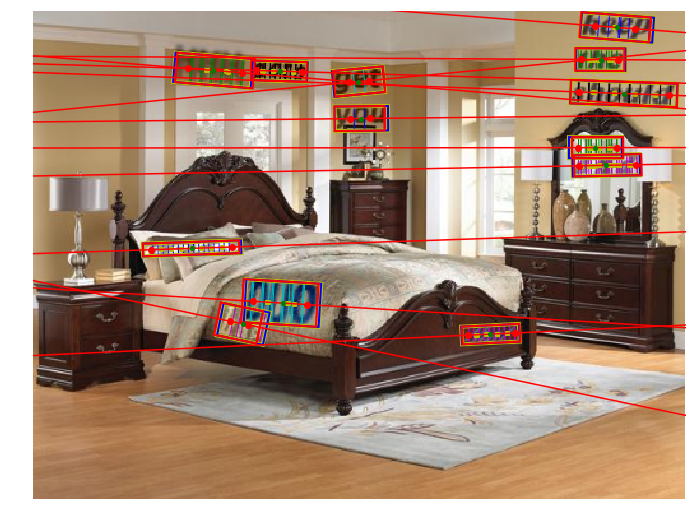

In [7]:
test_encoded_gt = prior_util.encode(test_gt)

dummy_output = np.copy(test_encoded_gt)
#dummy_output[:,2:4] += np.random.randn(*dummy_output[:,2:4].shape)*0.05

plt.figure(figsize=[12,9])
ax = plt.gca()
plt.imshow(test_img)
res = prior_util.decode(dummy_output, debug=False, debug_combining=True)
#res = decode(prior_util, dummy_output, debug=False)
prior_util.plot_gt()
prior_util.plot_results(res)
plt.axis('off'); plt.xlim(0, image_size[1]); plt.ylim(image_size[0],0)
plt.show()

### Training

In [ ]:
epochs = 100
initial_epoch = 0
batch_size = 6

experiment = 'sl384x512_synthtext'

prior_util = PriorUtil(model)
gen_train = InputGenerator(gt_util_train, prior_util, batch_size, model.image_size, augmentation=False)
gen_val = InputGenerator(gt_util_val, prior_util, batch_size, model.image_size, augmentation=False)

#for layer in model.layers:
#    layer.trainable = not layer.name in freeze

checkdir = './checkpoints/' + time.strftime('%Y%m%d%H%M') + '_' + experiment
if not os.path.exists(checkdir):
    os.makedirs(checkdir)

with open(checkdir+'/source.py','wb') as f:
    source = ''.join(['# In[%i]\n%s\n\n' % (i, In[i]) for i in range(len(In))])
    f.write(source.encode())

optim = keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=0.001, decay=0.0)
#optim = keras.optimizers.SGD(lr=1e-3, momentum=0.9, decay=0, nesterov=True)

# weight decay
regularizer = keras.regularizers.l2(5e-4) # None if disabled
for l in model.layers:
    if l.__class__.__name__.startswith('Conv'):
        l.kernel_regularizer = regularizer

#loss = SegLinkLoss(lambda_offsets=1.0, lambda_links=1.0, neg_pos_ratio=3.0)
loss = SegLinkFocalLoss(first_map_size=(192,256))

model.compile(optimizer=optim, loss=loss.compute, metrics=loss.metrics)

history = model.fit_generator(
        gen_train.generate(), #generator, 
        gen_train.num_batches, 
        epochs=epochs, 
        verbose=1, 
        callbacks=[
            keras.callbacks.ModelCheckpoint(checkdir+'/weights.{epoch:03d}.h5', verbose=1, save_weights_only=True),
            Logger(checkdir),
            #LearningRateDecay()
            ], 
        validation_data=gen_val.generate(), 
        validation_steps=gen_val.num_batches, 
        class_weight=None, 
        max_queue_size=1, 
        workers=1, 
        #use_multiprocessing=False, 
        initial_epoch=initial_epoch, 
        #pickle_safe=False, # will use threading instead of multiprocessing, which is lighter on memory use but slower
        )

### Predict

In [8]:
weights_path = './checkpoints/201806271040_sl384x512_synthtext/weights.016.h5'
#segment_threshold = 0.55; link_threshold = 0.35
segment_threshold = 0.50; link_threshold = 0.20
load_weights(model, weights_path)

In [9]:
_, inputs, images, data = gt_util_val.sample_random_batch(batch_size=16, input_size=image_size)

preds = model.predict(inputs, batch_size=1, verbose=1)

16/16 [==============================] - 2s 152ms/step


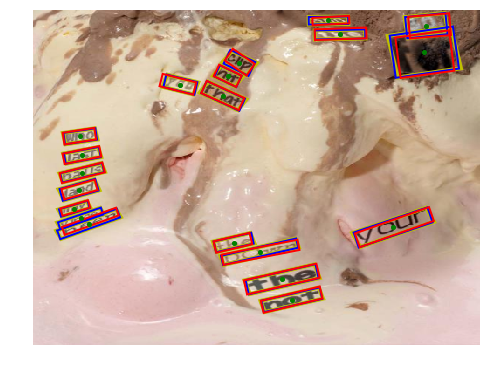

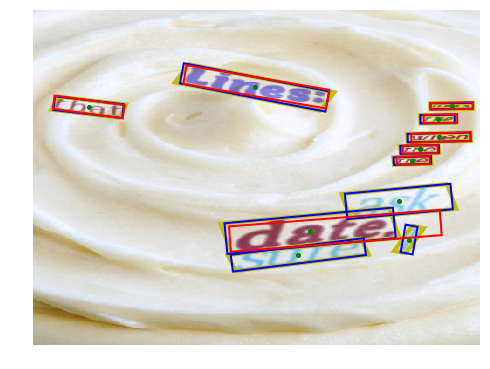

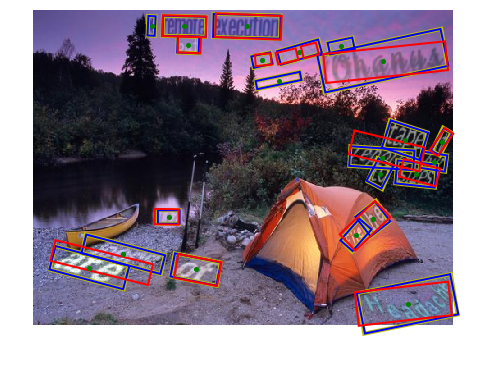

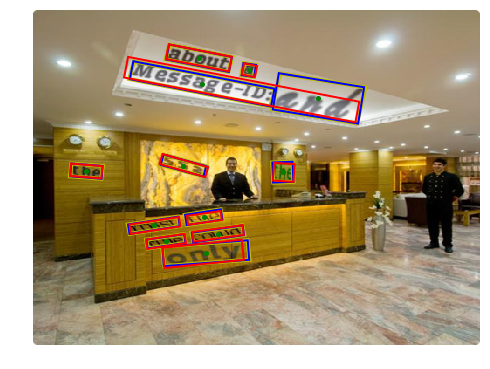

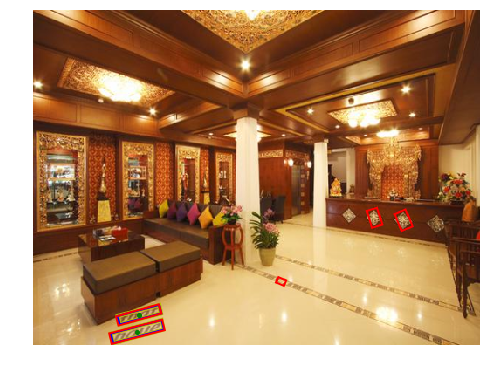

In [ ]:
results = [prior_util.decode(p, segment_threshold, link_threshold) for p in preds]

for i in range(5):
    plt.figure(figsize=[8]*2)
    plt.imshow(images[i])
    prior_util.encode(data[i])
    prior_util.plot_gt()
    prior_util.plot_results(results[i])
    plt.axis('off')
    #plt.savefig('plots/%s_test_%03i.pgf' % (plot_name, i), bbox_inches='tight')
    plt.show()

In [ ]:
steps_seg = np.arange(0.1, 1, 0.1)
steps_lnk = np.arange(0.1, 1, 0.1)

fmes_grid = np.zeros((len(steps_seg),len(steps_lnk)))

for i, st in enumerate(steps_seg):
    for j, lt in enumerate(steps_lnk):
        results = [prior_util.decode(p, st, lt) for p in preds]
        TP, FP, FN = evaluate_results(data, results)
        recall = TP / (TP+FN)
        precision = TP / (TP+FP)
        fmes = fscore(precision, recall)
        fmes_grid[i,j] = fmes
        print('segment_threshold %.2f link_threshold %.2f f-measure %.2f' % (st, lt, fmes))
        
print(fmes_grid)

segment_threshold 0.10 link_threshold 0.10 f-measure 0.01
segment_threshold 0.10 link_threshold 0.20 f-measure 0.02
segment_threshold 0.10 link_threshold 0.30 f-measure 0.01
segment_threshold 0.10 link_threshold 0.40 f-measure 0.01
segment_threshold 0.10 link_threshold 0.50 f-measure 0.01
segment_threshold 0.10 link_threshold 0.60 f-measure 0.01
segment_threshold 0.10 link_threshold 0.70 f-measure 0.00
segment_threshold 0.10 link_threshold 0.80 f-measure 0.00
segment_threshold 0.10 link_threshold 0.90 f-measure 0.00
segment_threshold 0.20 link_threshold 0.10 f-measure 0.07
segment_threshold 0.20 link_threshold 0.20 f-measure 0.06
segment_threshold 0.20 link_threshold 0.30 f-measure 0.03
segment_threshold 0.20 link_threshold 0.40 f-measure 0.03
segment_threshold 0.20 link_threshold 0.50 f-measure 0.02
segment_threshold 0.20 link_threshold 0.60 f-measure 0.01
segment_threshold 0.20 link_threshold 0.70 f-measure 0.01
segment_threshold 0.20 link_threshold 0.80 f-measure 0.01
segment_thresh

In [ ]:
max_idx = np.argmax(fmes_grid)
max_idx1 = max_idx//fmes_grid.shape[0]
max_idx2 = max_idx%fmes_grid.shape[0]
print(steps_seg[max_idx1], steps_seg[max_idx2], fmes_grid[max_idx1,max_idx2])
plt.figure(figsize=[8]*2)
plt.imshow(fmes_grid, cmap='jet', origin='lower', interpolation='bicubic') # nearest, bilinear, bicubic
plt.title('f-measure')
plt.xticks(range(len(steps_lnk)), steps_lnk.astype('float32'))
plt.yticks(range(len(steps_seg)), steps_seg.astype('float32'))
plt.plot(max_idx2, max_idx1, 'or')
plt.xlabel('link_threshold')
plt.ylabel('segment_threshold')
plt.grid()
#plt.savefig('plots/%s_gridsearch.pgf' % (plot_name), bbox_inches='tight')
plt.show()